In [289]:
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
from astroML.datasets import fetch_sdss_spectrum
import multiprocessing
import pandas as pd
from functools import partial
import numpy as np
import glob
import re
import csv
import seaborn as sns
import pandas as pd


plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 10

# Construct files 

In [324]:
## file containing the basic infotmation of all Type I AGNs
typeIList = Table.read('typeIList.fits', format='fits').to_pandas()

## file containing the fittings all Type I AGNs
typeIFitting = Table.read('typeIFitting.fits', format='fits').to_pandas()

## file containing all galaxies
galaxy = Table.read('sdss_dr7_catalog_galaxies.fits', format='fits').to_pandas()

## file containing all QSOs
QSO = Table.read('sdss_dr7_catalog_qso.fits', format='fits').to_pandas()

# merge to have complete type I information
typeI = typeIList.merge(typeIFitting, right_on=['ID'],left_on=['ID'], how='inner')

# filter galaxy and quasar of type I
galaxyTypeI = galaxy.merge(typeI, right_on=['RA','DEC','Z','PLATE','MJD','FIBERID'],left_on=['RA','DEC','Z','PLATE','MJD','FIBERID'], how='inner')
QSOTypeI = QSO.merge(typeI, right_on=['RA','DEC','Z','PLATE','MJD','FIBERID'],left_on=['RA','DEC','Z','PLATE','MJD','FIBERID'], how='inner')

## Type sample: select redshift < 0.2 and log(L[OIII]) > 40.125

In [325]:
galaxyTypeIZ02 = galaxyTypeI[(galaxyTypeI['Z']<0.2) & (galaxyTypeI['Z']>0.0) & (galaxyTypeI['LOIII5007']>40.125) ]
galaxyTypeIZ02.to_csv('galaxyTypeIZ02.csv',index=False)
print(len(galaxyTypeIZ02))

2924


In [326]:
QSOTypeIZ02 = galaxyTypeI[(QSOTypeI['Z']<0.2) & (QSOTypeI['Z']>0.0) & (QSOTypeI['LOIII5007']>40.125) ]
QSOTypeIZ02.to_csv('QSOTypeIZ02.csv',index=False)
print(len(QSOTypeIZ02))

1817


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


## Seyfert sample

In [328]:
sy19_filenames = glob.glob('../Sy19_train/*.fits')+glob.glob('../Sy19_test/*.fits')
sy20_filenames = glob.glob('../Sy20_train/*.fits')+glob.glob('../Sy20_test/*.fits')

sy19_list = [re.findall(r'\d+', filename) for filename in sy19_filenames]
sy20_list = [re.findall(r'\d+', filename) for filename in sy20_filenames]

sy19 = pd.DataFrame(sy19_list, columns=["CLASS", "PLATE", "MJD", "FIBERID"], dtype='int')
sy20 = pd.DataFrame(sy20_list, columns=["CLASS", "PLATE", "MJD", "FIBERID"], dtype='int')

print(len(sy19))
print(len(sy20))

745
54694


In [329]:
sy19.to_csv('sy19.csv',index=False)
sy20.to_csv('sy20.csv',index=False)

# check duplicate

In [330]:
print('galaxy:', len(galaxy))
print('QSO:', len(QSO))
print('galaxyTypeIZ02:', len(galaxyTypeIZ02))
print('QSOTypeIZ02:', len(QSOTypeIZ02))
print('sy19:', len(sy19))
print('sy20:', len(sy20))

galaxy: 929555
QSO: 121363
galaxyTypeIZ02: 2924
QSOTypeIZ02: 1817
sy19: 745
sy20: 54694


In [532]:
galaxy_sy19 = galaxy.merge(sy19, right_on=['PLATE','MJD','FIBERID'],left_on=['PLATE','MJD','FIBERID'], how='inner')
QSO_sy19 = QSO.merge(sy19, right_on=['PLATE','MJD','FIBERID'],left_on=['PLATE','MJD','FIBERID'], how='inner')
print('In',len(sy19), 'sy19,',len(galaxy_sy19),'belong to galaxy, and', len(QSO_sy19), 'belong to  QSO.')

In 745 sy19, 259 belong to galaxy, and 486 belong to  QSO.


259+486=745, so the original dataset of type I paper covers the sy19 in Seyfert paper.

In [336]:
galaxyTypeIZ02_sy19 = galaxyTypeIZ02.merge(sy19, right_on=['PLATE','MJD','FIBERID'],left_on=['PLATE','MJD','FIBERID'], how='inner')
QSOTypeIZ02_sy19 = QSOTypeIZ02.merge(sy19, right_on=['PLATE','MJD','FIBERID'],left_on=['PLATE','MJD','FIBERID'], how='inner')
print('In',len(sy19), 'sy19,',len(galaxyTypeIZ02_sy19),'belong to type I galaxy, and', len(QSOTypeIZ02_sy19), 'belong to type I QSO (Z<0.2).')

In 745 sy19, 224 belong to type I galaxy, and 99 belong to type I QSO (Z<0.2).


224+99=323, smaller than 745, therefore many of sy19 are classified as others (Linear?) in Type I paper.

In [333]:
galaxy_sy20 = galaxy.merge(sy20, right_on=['PLATE','MJD','FIBERID'],left_on=['PLATE','MJD','FIBERID'], how='inner')
QSO_sy20 = QSO.merge(sy20, right_on=['PLATE','MJD','FIBERID'],left_on=['PLATE','MJD','FIBERID'], how='inner')
print('In',len(sy20), 'sy20,',len(galaxy_sy20),'belong to galaxy, and', len(QSO_sy20), 'belong to  QSO.')

In 54694 sy20, 53912 belong to galaxy, and 750 belong to  QSO.


In [335]:
galaxyTypeIZ02_sy20 = galaxyTypeIZ02.merge(sy20, right_on=['PLATE','MJD','FIBERID'],left_on=['PLATE','MJD','FIBERID'], how='inner')
QSOTypeIZ02_sy20 = QSOTypeIZ02.merge(sy20, right_on=['PLATE','MJD','FIBERID'],left_on=['PLATE','MJD','FIBERID'], how='inner')
print('In',len(sy20), 'sy20,',len(galaxyTypeIZ02_sy20),'belong to type I galaxy, and', len(QSOTypeIZ02_sy20), 'belong to type I QSO (Z<0.2).')

In 54694 sy20, 1809 belong to type I galaxy, and 722 belong to type I QSO (Z<0.2).


To construct type I from galaxyTypeIZ02_sy20 and type II from sy20:

**Decision:**
- Method one: only delete from sy20 the 1809 belong to type I galaxy and 750 belong to  QSO.
- method two: adopting method 1, and also detele from  type I galaxy both the 1809 ones.

## Method 1
Method one: delete from sy20 the 1809 belong to type I galaxy and 750 belong to QSO.

In [521]:
## https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe

# 1. delete 750 belong to QSO
print(len(sy20),'- 750')
sy20d_left = sy20.merge(QSO_sy20[QSO_sy20.columns[2:5]].drop_duplicates(), on=['PLATE','MJD','FIBERID'],  how='left', indicator=True)
sy20d = sy20d_left[sy20d_left['_merge'] == 'left_only'].drop(columns='_merge')

# 2. delete 1809 belong to type I galaxy
print(len(sy20d),'- 1809')
sy20d_left = sy20d.merge(galaxyTypeIZ02_sy20.drop_duplicates(), on=['PLATE','MJD','FIBERID'],  how='left', indicator=True)
sy20d = sy20d_left[sy20d_left['_merge'] == 'left_only'].drop(columns='_merge')
print(len(sy20d))

54694 - 750
53944 - 1809
52135


In [522]:
sy20d[sy20d.columns[:4]].to_csv('sy20d.csv',index=False)

## Method 2
method two: adopting method 1, and also detele from type I galaxy both the 1809 ones.

In [407]:
print(len(galaxyTypeIZ02),'- 1809')
galaxyTypeIZ02_left = galaxyTypeIZ02.merge(galaxyTypeIZ02_sy20[galaxyTypeIZ02_sy20.columns[2:5]].drop_duplicates(), on=['PLATE','MJD','FIBERID'],  how='left', indicator=True)
galaxyTypeIZ02d = galaxyTypeIZ02_left[galaxyTypeIZ02_left['_merge'] == 'left_only'].drop(columns='_merge')
print(len(galaxyTypeIZ02d))

2924 - 1809
1115


In [411]:
# galaxyTypeIZ02d.to_csv('galaxyd.csv',index=False)

# Line width (No deletion of Type I galaxies)

Doppler effect
$\Delta \lambda /\lambda = v/c$

Calculate full width of lines from the velocity unit of  Full width at half maximum (FWHM),
FWHM = 2.355 sigma.


Though idealy the width of different lines shall follow the ratio of $\lambda_1 /\lambda_1$, but the weak intesity of some emission lines makes the width smaller.

In [491]:
HA = 6564.613894
HB = 4862.682994
OIII5007 = 5008.239638

In [515]:
type1_FWHM_BHA = galaxyTypeIZ02['FWHM_BHA']
type1_FWHM_BHB = galaxyTypeIZ02['FWHM_BHB']

type1_FWHM_OIII5007 = galaxyTypeIZ02['FWHM_OIII5007']

In [516]:
type1Width_BHA=(type1_FWHM_BHA/3e5)*HA/2.355*2*2
type1Width_BHB=(type1_FWHM_BHB/3e5)*HB/2.355*2*2

type1Width_OIII5007=(type1_FWHM_OIII5007/3e5)*OIII5007/2.355*2*2

In [517]:
print('HA percentage < linewidth 250:', len(type1Width_BHA[type1Width_BHA<250])/len(type1Width_BHA))
print('FWHM of linewidth 250:', 250/2/2*2.355/HA*3e5)

HA percentage < linewidth 250: 0.9514363885088919
FWHM of linewidth 250: 6726.404738039267


In [518]:
print('HB percentage < linewidth 190:', len(type1Width_BHB[type1Width_BHB<190])/len(type1Width_BHB))
print('FWHM of linewidth 190:', 190/2/2*2.355/HB*3e5)

HB percentage < linewidth 190: 0.9517783857729138
FWHM of linewidth 190: 6901.282695460037


In [519]:
print('OIII5007 percentage < linewidth 22:', len(type1Width_OIII5007[type1Width_OIII5007<22])/len(type1Width_OIII5007))
print('FWHM of linewidth 22:', 22/2/2*2.355/OIII5007*3e5)

OIII5007 percentage < linewidth 22: 0.9897400820793434
FWHM of linewidth 22: 775.8714200728108


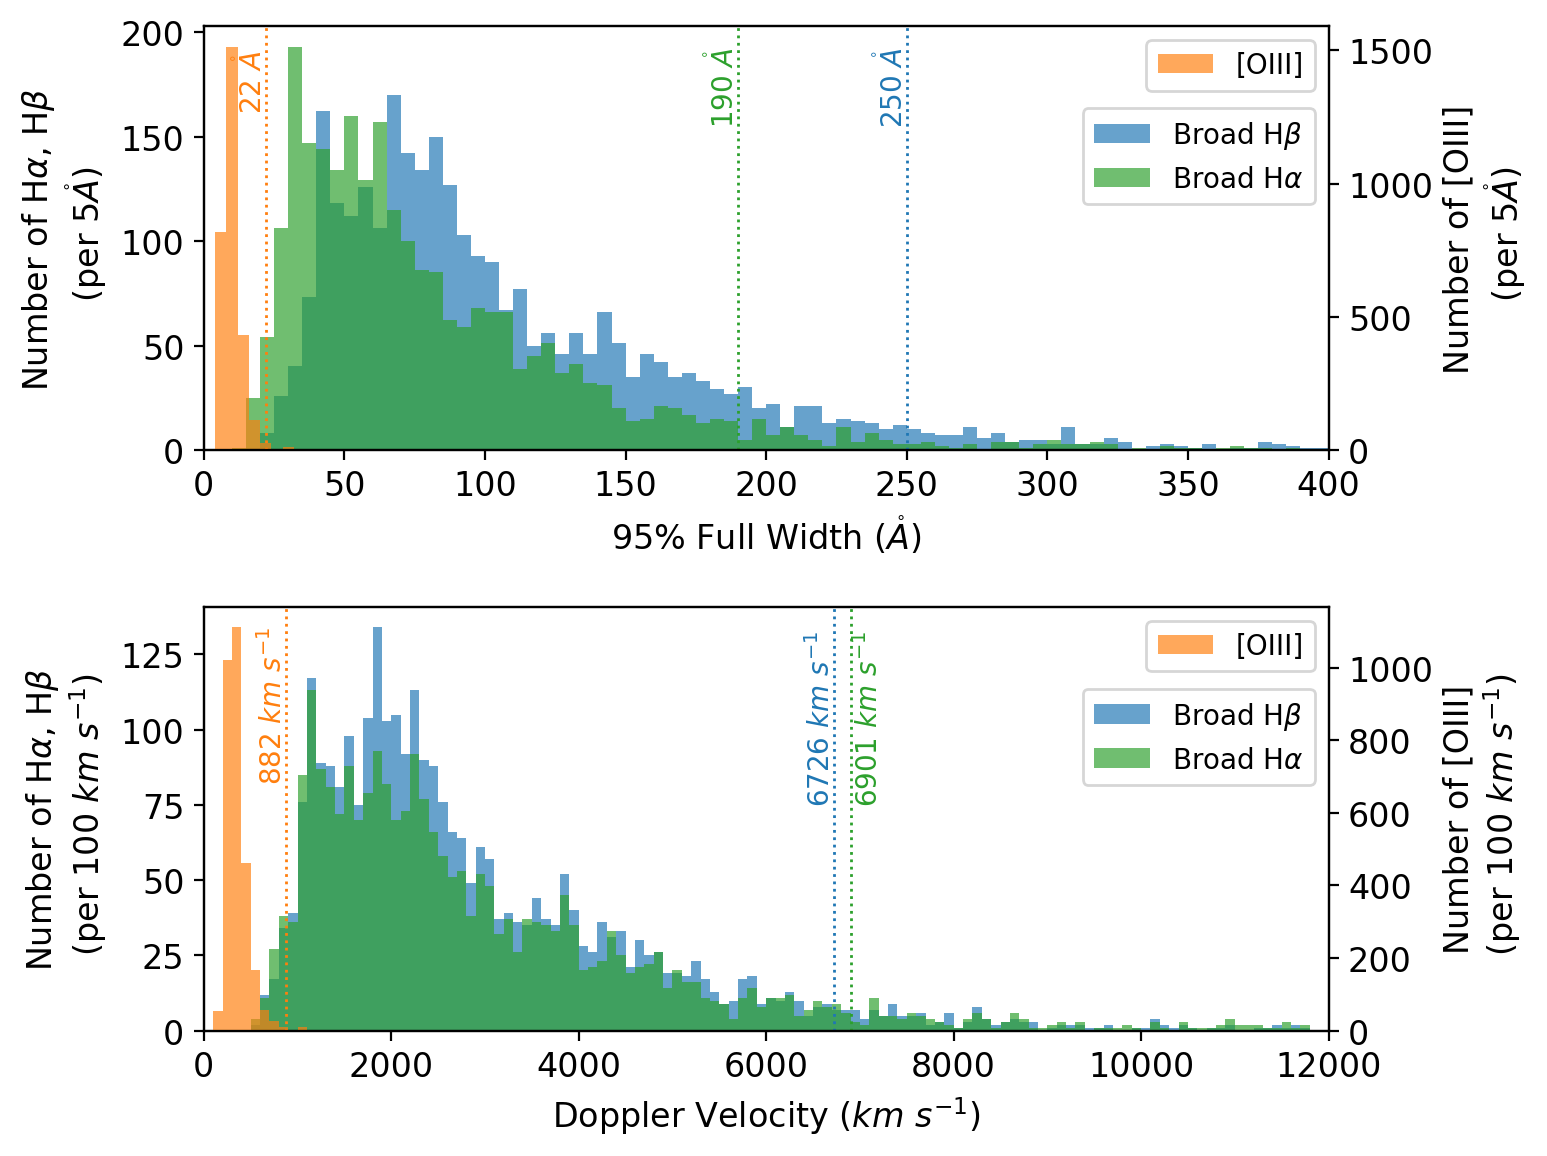

In [520]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=False, sharey=False)
plt.subplots_adjust(hspace=0.4, wspace = 0.05)

ax1 = plt.subplot(211)
ax1r = ax1.twinx()

ax1.hist(type1Width_BHA,bins=np.linspace(0,500,101),color='C0',alpha=0.68, label=r'Broad H$\beta$')
ax1.hist(type1Width_BHB,bins=np.linspace(0,500,101),color='C2',alpha=0.68, label=r'Broad H$\alpha$')
ax1.axvline(x=250, color='C0', linewidth=1, linestyle='dotted')
ax1.axvline(x=190, color='C2', linewidth=1, linestyle='dotted')
ax1.annotate('250 $\mathring{A}$', xy=(239,180), rotation=90, fontsize=10, color='C0')
ax1.annotate('190 $\mathring{A}$', xy=(179,180), rotation=90, fontsize=10, color='C2')
ax1.legend(fontsize=10,bbox_to_anchor=(0.9999,0.84))

ax1r.hist(type1Width_OIII5007,bins=np.linspace(0,400,101),color='C1',alpha=0.68, label='[OIII]')
ax1r.axvline(x=22, color='C1', linewidth=1, linestyle='dotted')
ax1r.annotate('22 $\mathring{A}$', xy=(11,1400), rotation=90, fontsize=10, color='C1')
ax1r.legend(fontsize=10)

plt.xlim(0,400)
ax1.set_xlabel('95% Full Width ($\mathring{A}$)',fontsize=12)
ax1.set_ylabel('Number of H$\\alpha$, H$\\beta$\n (per 5$\mathring{A}$)',fontsize=12)
ax1r.set_ylabel('Number of [OIII]\n (per 5$\mathring{A}$)',fontsize=12)


#######################

ax2 = plt.subplot(212)
ax2r = ax2.twinx()

ax2.hist(type1_FWHM_BHA,bins=np.linspace(0,12000,121),color='C0',alpha=0.68, label=r'Broad H$\beta$')
ax2.hist(type1_FWHM_BHB,bins=np.linspace(0,12000,121),color='C2',alpha=0.68, label=r'Broad H$\alpha$')
ax2.axvline(x=6726, color='C0', linewidth=1, linestyle='dotted')
ax2.axvline(x=6901, color='C2', linewidth=1, linestyle='dotted')
ax2.annotate('6726 $km$ $s^{-1}$', xy=(6426,125), rotation=90, fontsize=10, color='C0')
ax2.annotate('6901 $km$ $s^{-1}$', xy=(6941,125), rotation=90, fontsize=10, color='C2')
ax2.legend(fontsize=10,bbox_to_anchor=(0.9999,0.84))

ax2r.hist(type1_FWHM_OIII5007,bins=np.linspace(0,10000,101),color='C1',alpha=0.68, label='[OIII]')
ax2r.axvline(x=882, color='C1', linewidth=1, linestyle='dotted')
ax2r.annotate('882 $km$ $s^{-1}$', xy=(579,1050), rotation=90, fontsize=10, color='C1')
plt.xlim(0,12000)
ax2r.legend(fontsize=10)
ax2.set_xlabel('Doppler Velocity ($km$ $s^{-1}$)',fontsize=12)
ax2.set_ylabel('Number of H$\\alpha$, H$\\beta$\n (per 100 $km$ $s^{-1}$)',fontsize=12)
ax2r.set_ylabel('Number of [OIII]\n (per 100 $km$ $s^{-1}$)',fontsize=12)

fig.tight_layout()
plt.savefig('lineWidth.pdf', format='pdf')

# Line width (Yes deletion of Type I galaxies)

**using galaxyTypeIZ02d**

In [504]:
HA = 6564.613894
HB = 4862.682994
OIII5007 = 5008.239638

In [505]:
type1_FWHM_BHA = galaxyTypeIZ02d['FWHM_BHA']
type1_FWHM_BHB = galaxyTypeIZ02d['FWHM_BHB']

type1_FWHM_OIII5007 = galaxyTypeIZ02d['FWHM_OIII5007']

In [506]:
type1Width_BHA=(type1_FWHM_BHA/3e5)*HA/2.355*2*2
type1Width_BHB=(type1_FWHM_BHB/3e5)*HB/2.355*2*2

type1Width_OIII5007=(type1_FWHM_OIII5007/3e5)*OIII5007/2.355*2*2

In [507]:
print('HA percentage < linewidth 265:', len(type1Width_BHA[type1Width_BHA<265])/len(type1Width_BHA))
print('FWHM of linewidth 265:', 265/2/2*2.355/HA*3e5)

HA percentage < linewidth 265: 0.9506726457399103
FWHM of linewidth 265: 7129.9890223216225


In [508]:
print('HB percentage < linewidth 210:', len(type1Width_BHB[type1Width_BHB<210])/len(type1Width_BHB))
print('FWHM of linewidth 210:', 210/2/2*2.355/HB*3e5)

HB percentage < linewidth 210: 0.9497757847533632
FWHM of linewidth 210: 7627.733505508462


In [509]:
print('OIII5007 percentage < linewidth 25:', len(type1Width_OIII5007[type1Width_OIII5007<25])/len(type1Width_OIII5007))
print('FWHM of linewidth 22:', 25/2/2*2.355/OIII5007*3e5)

OIII5007 percentage < linewidth 25: 0.9937219730941704
FWHM of linewidth 22: 881.6720682645578


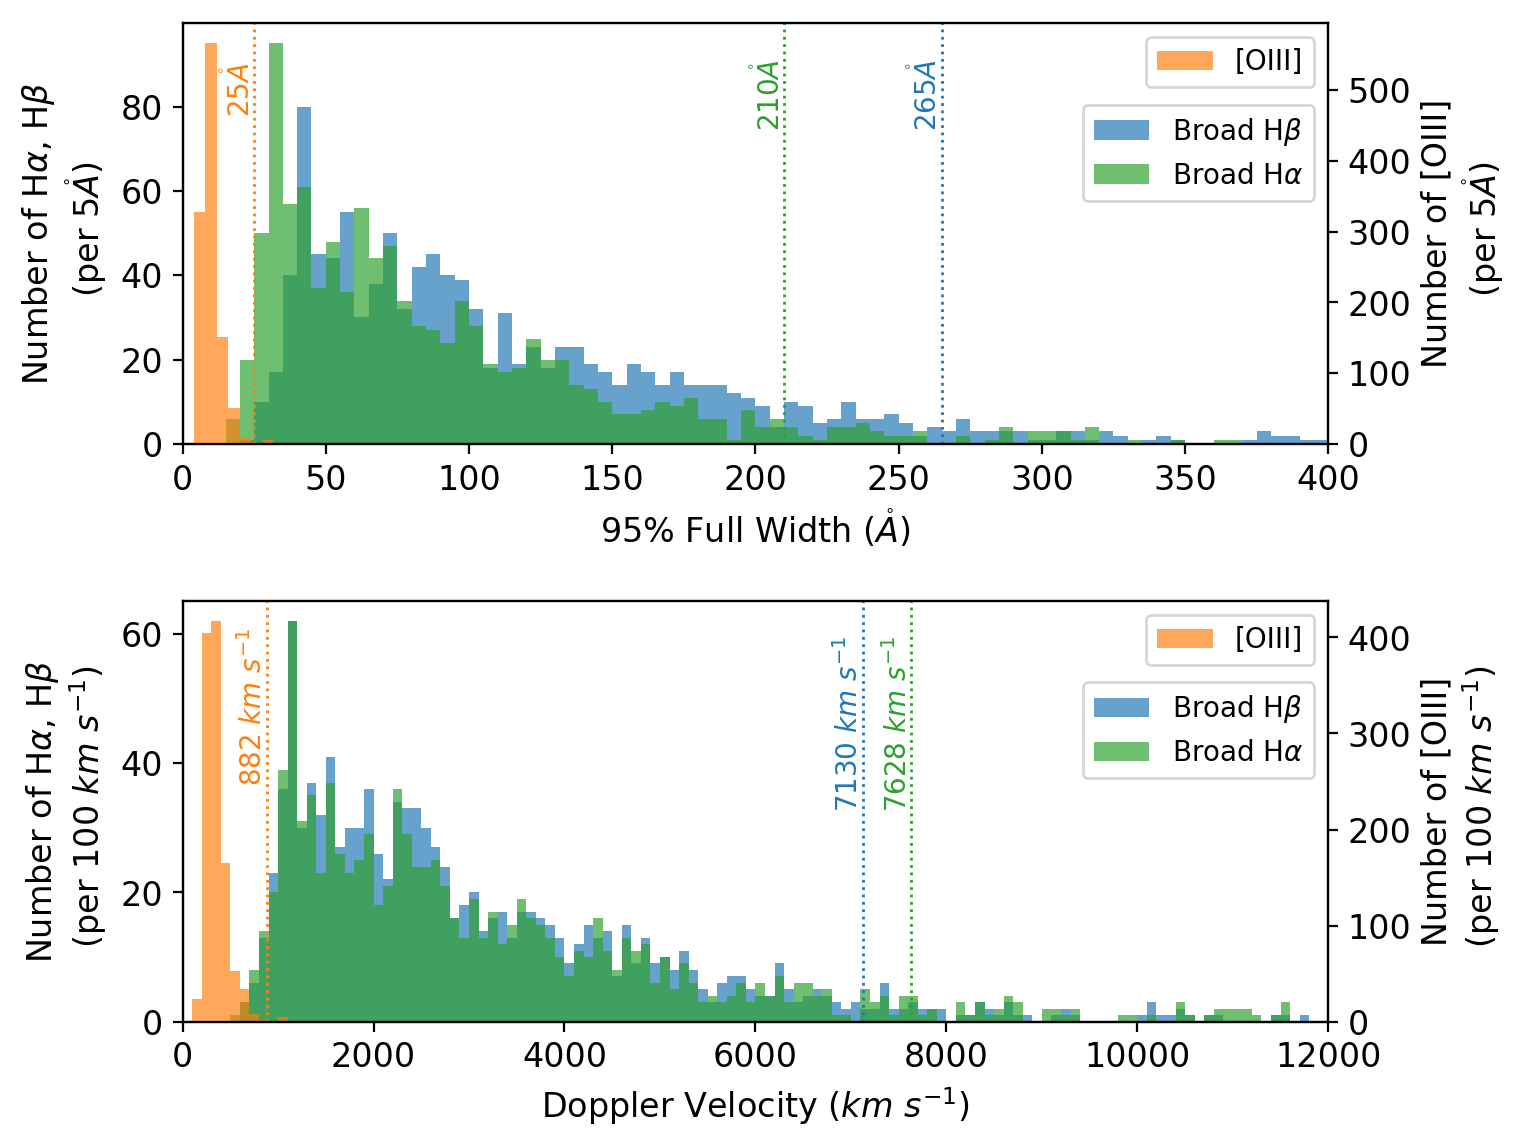

In [514]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=False, sharey=False)
plt.subplots_adjust(hspace=0.4, wspace = 0.05)

ax1 = plt.subplot(211)
ax1r = ax1.twinx()

ax1.hist(type1Width_BHA,bins=np.linspace(0,500,101),color='C0',alpha=0.68, label=r'Broad H$\beta$')
ax1.hist(type1Width_BHB,bins=np.linspace(0,500,101),color='C2',alpha=0.68, label=r'Broad H$\alpha$')
ax1.axvline(x=265, color='C0', linewidth=1, linestyle='dotted')
ax1.axvline(x=210, color='C2', linewidth=1, linestyle='dotted')
ax1.annotate('265$\mathring{A}$', xy=(254,85), rotation=90, fontsize=10, color='C0')
ax1.annotate('210$\mathring{A}$', xy=(199,85), rotation=90, fontsize=10, color='C2')
ax1.legend(fontsize=10,bbox_to_anchor=(0.9999,0.84))

ax1r.hist(type1Width_OIII5007,bins=np.linspace(0,400,101),color='C1',alpha=0.68, label='[OIII]')
ax1r.axvline(x=25, color='C1', linewidth=1, linestyle='dotted')
ax1r.annotate('25$\mathring{A}$', xy=(14,500), rotation=90, fontsize=10, color='C1')
ax1r.legend(fontsize=10)

plt.xlim(0,400)
ax1.set_xlabel('95% Full Width ($\mathring{A}$)',fontsize=12)
ax1.set_ylabel('Number of H$\\alpha$, H$\\beta$\n (per 5$\mathring{A}$)',fontsize=12)
ax1r.set_ylabel('Number of [OIII]\n (per 5$\mathring{A}$)',fontsize=12)


#######################

ax2 = plt.subplot(212)
ax2r = ax2.twinx()

ax2.hist(type1_FWHM_BHA,bins=np.linspace(0,12000,121),color='C0',alpha=0.68, label=r'Broad H$\beta$')
ax2.hist(type1_FWHM_BHB,bins=np.linspace(0,12000,121),color='C2',alpha=0.68, label=r'Broad H$\alpha$')
ax2.axvline(x=7130, color='C0', linewidth=1, linestyle='dotted')
ax2.axvline(x=7628, color='C2', linewidth=1, linestyle='dotted')
ax2.annotate('7130 $km$ $s^{-1}$', xy=(6826,56), rotation=90, fontsize=10, color='C0')
ax2.annotate('7628 $km$ $s^{-1}$', xy=(7341,56), rotation=90, fontsize=10, color='C2')
ax2.legend(fontsize=10,bbox_to_anchor=(0.9999,0.84))

ax2r.hist(type1_FWHM_OIII5007,bins=np.linspace(0,10000,101),color='C1',alpha=0.68, label='[OIII]')
ax2r.axvline(x=882, color='C1', linewidth=1, linestyle='dotted')
ax2r.annotate('882 $km$ $s^{-1}$', xy=(579,385), rotation=90, fontsize=10, color='C1')
plt.xlim(0,12000)
ax2r.legend(fontsize=10)
ax2.set_xlabel('Doppler Velocity ($km$ $s^{-1}$)',fontsize=12)
ax2.set_ylabel('Number of H$\\alpha$, H$\\beta$\n (per 100 $km$ $s^{-1}$)',fontsize=12)
ax2r.set_ylabel('Number of [OIII]\n (per 100 $km$ $s^{-1}$)',fontsize=12)

fig.tight_layout()
plt.savefig('lineWidth_d.pdf', format='pdf')

# Filter those ones larger than the width

Only filter Halpha and Hbeta

In [537]:
galaxyTypeIZ02 = galaxyTypeIZ02[(galaxyTypeIZ02['FWHM_BHA']<6726) & (galaxyTypeIZ02['FWHM_BHB']<6901)]
galaxyTypeIZ02.to_csv('galaxy.csv',index=False)
len(galaxyTypeIZ02)

2747

In [540]:
galaxyTypeIZ02d = galaxyTypeIZ02d[(galaxyTypeIZ02d['FWHM_BHA']<7130) & (galaxyTypeIZ02d['FWHM_BHB']<7628)]
galaxyTypeIZ02d.to_csv('galaxyd.csv',index=False)
len(galaxyTypeIZ02d)

1047